# Seq2Seq Language Translation model, word model with attention

### Rosie Nguyen

### See Datasets: http://www.manythings.org/anki/

### Import Libraries

In [ ]:
pip install tensorflow_text

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import string
from string import digits
import re
from sklearn.utils import shuffle
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Input, Dense,Embedding
from keras.models import Model,load_model
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import Tokenizer
from keras.models import model_from_json
import pickle as pkl
import numpy as np
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import typing
from typing import Any, Tuple
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow_text as tf_text
import matplotlib.ticker as ticker

We will need to build a few layers from scratch, use this variable to switch between the custom and builtin implementations.

In [ ]:
use_builtins = True

the shape checker class is used to check shapes throughout the tutorial.

In [ ]:
#Shape checker
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    if isinstance(names, str):
      names = (names,)

    shape = tf.shape(tensor)
    rank = tf.rank(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')

    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

### Load the data

In [ ]:
#load raw text data file.
df=pd.read_csv('vie.txt',delimiter="\t", header=None)
#name the columns
df.columns = ['English', 'Vietnamese', 'Others']
df.head()

,English,Vietnamese,Others
0,Run!,Chạy!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
1,Help!,Giúp tôi với!,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
2,Go on.,Tiếp tục đi.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,Hello!,Chào bạn.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
4,Hurry!,Nhanh lên nào!,CC-BY 2.0 (France) Attribution: tatoeba.org #1...


### Text Preprocessing 

**Remove unnecessary columns, shuffle rows but keep the correlatio between English and Vietnamese columns**

In [ ]:
#remove column others
df= df.drop(columns= 'Others') 
#shuffle the rows but still keep the correct translation orders
df= df.reindex(np.random.permutation(df.index))
df.head()

,English,Vietnamese
6626,There are times when we have to hide the truth.,Có những lúc mà chúng ta phải che giấu đi sự t...
2967,When was printing invented?,Việc in ấn ra đời khi nào?
199,I play tennis.,Tôi chơi môn quần vợt.
3413,She is a friend of my wife's.,Nó là bạn của vợ tao.
3633,I was amazed to learn I'd won.,Tôi đã ngạc nhiên khi biết được là tôi đã thắng.


**Text processing: convert to lowercase, remove punctuation, remove whitespaces at the start and end of sentences**

In [ ]:
#text preprocessing
targ = df['English'].values
inp = df['Vietnamese'].values
print(inp[-1])
print(targ[-1])

Tôi không học được gì từ giáo viên đó cả.
I learned nothing from the teacher.


**Create a tf.data dataset**

In [ ]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [ ]:
for example_input_batch, example_target_batch in dataset.take(1):
  print(example_input_batch[:5])
  print()
  print(example_target_batch[:5])
  break

tf.Tensor(
[b'T\xc3\xb4i c\xe1\xba\xa7n th\xc3\xaam n\xe1\xbb\xafa.'
 b'T\xc3\xb4i \xc4\x91\xc3\xa3 gi\xc3\xbap Tom s\xc6\xa1n c\xc3\xa1i h\xc3\xa0ng r\xc3\xa0o \xc4\x91\xc3\xb3.'
 b'T\xc3\xb4i nghi\xc3\xaan c\xe1\xbb\xa9u nhi\xe1\xbb\x81u gi\xe1\xbb\x9d li\xe1\xbb\x81n v\xc3\xa0o bu\xe1\xbb\x95i t\xe1\xbb\x91i.'
 b'\xc4\x90\xe1\xbb\xabng ngh\xc4\xa9 l\xc3\xa0 t\xc3\xb4i \xc4\x91\xc3\xa3 kh\xc3\xb4ng th\xe1\xbb\xad.'
 b'B\xe1\xba\xa1n ngh\xc4\xa9 \xc4\x91i\xe1\xbb\x81u g\xc3\xac \xc4\x91\xc3\xa3 g\xc3\xa2y ra m\xc3\xa2u thu\xe1\xba\xabn trong ho\xe1\xba\xa1t \xc4\x91\xe1\xbb\x99ng th\xc6\xb0\xc6\xa1ng m\xe1\xba\xa1i gi\xe1\xbb\xafa Nh\xe1\xba\xadt B\xe1\xba\xa3n v\xc3\xa0 Hoa K\xe1\xbb\xb3?'], shape=(5,), dtype=string)

tf.Tensor(
[b'I need more.' b'I helped Tom paint the fence.'
 b'I study for many hours at night.' b"Don't think I didn't try."
 b'What do you think has caused the present trade friction between Japan and the U.S.?'], shape=(5,), dtype=string)


**Standardization**

The model is dealing with multilingual text with a limited vocabulary. So it will be important to standardize the input text.
The first step is Unicode normalization to split accented characters and replace compatibility characters with their ASCII equivalents.
The tensroflow_text package contains a unicode normalize operation:

In [ ]:
example_text = tf.constant('Bộ phim này được dựa trên một cuốn tiểu thuyết')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'B\xe1\xbb\x99 phim n\xc3\xa0y \xc4\x91\xc6\xb0\xe1\xbb\xa3c d\xe1\xbb\xb1a tr\xc3\xaan m\xe1\xbb\x99t cu\xe1\xbb\x91n ti\xe1\xbb\x83u thuy\xe1\xba\xbft'
b'Bo\xcc\xa3\xcc\x82 phim na\xcc\x80y \xc4\x91u\xcc\x9bo\xcc\x9b\xcc\xa3c du\xcc\x9b\xcc\xa3a tre\xcc\x82n mo\xcc\xa3\xcc\x82t cuo\xcc\x82\xcc\x81n tie\xcc\x82\xcc\x89u thuye\xcc\x82\xcc\x81t'


In [ ]:
def tf_lower_and_split_punct(text):
  # Split accecented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-zđ.?!,]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [ ]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

Bộ phim này được dựa trên một cuốn tiểu thuyết
[START] bo phim nay đuoc dua tren mot cuon tieu thuyet [END]


**Text Vectorization**

TextVectorization layer will handle the vocabulary extraction and conversion of input text to sequences of tokens.

In [ ]:
max_vocab_size = 5000

input_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

In [ ]:
#vietnamsese vocabulary 
input_text_processor.adapt(inp)

# the first 10 words from the vocabulary:
input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'toi', 'khong', 'co', 'ban', 'tom']

In [ ]:
#english vocabulary 
output_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'i', 'to', 'the', 'tom', 'you']

In [ ]:
#convert a batch of strings into a batch of token IDs:
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[  2,   5,  79, 203, 116,   4,   3,   0,   0,   0],
       [  2,   5,  11, 136,   9, 609,  34, 215, 592,  16],
       [  2,   5, 576, 361,  67,  61, 430,  50, 268,   5]], dtype=int64)>

In [ ]:
#convert token IDs back to text
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] toi can them nua . [END]                '

Text(0.5, 1.0, 'Mask')

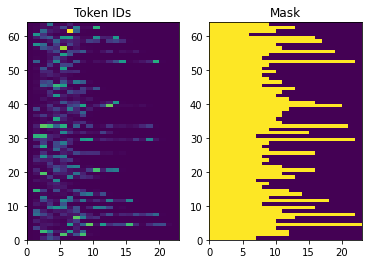

In [ ]:
#The returned token IDs are zero-padded. This can easily be turned into a mask
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

### The encoder/decoder model

In [ ]:
embedding_dim = 256
units = 1024

**The encoder**

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):
    shape_checker = ShapeChecker()
    shape_checker(tokens, ('batch', 's'))

    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)
    shape_checker(vectors, ('batch', 's', 'embed_dim'))

    # 3. The GRU processes the embedding sequence.
    #    output shape: (batch, s, enc_units)
    #    state shape: (batch, enc_units)
    output, state = self.gru(vectors, initial_state=state)
    shape_checker(output, ('batch', 's', 'enc_units'))
    shape_checker(state, ('batch', 'enc_units'))

    # 4. Returns the new sequence and its state.
    return output, state

In [ ]:
# Convert the input text to tokens.
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 23)
Encoder output, shape (batch, s, units): (64, 23, 1024)
Encoder state, shape (batch, units): (64, 1024)


**The attention head**

The decoder uses attention to selectively focus on parts of the input sequence. The attention takes a sequence of vectors as input for each example and returns an "attention" vector for each example. This attention layer is similar to a layers.GlobalAveragePoling1D but the attention layer performs a weighted average.

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    shape_checker = ShapeChecker()
    shape_checker(query, ('batch', 't', 'query_units'))
    shape_checker(value, ('batch', 's', 'value_units'))
    shape_checker(mask, ('batch', 's'))

    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)
    shape_checker(w1_query, ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)
    shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    shape_checker(context_vector, ('batch', 't', 'value_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

**Test the Attention layer**

In [ ]:
#Create a BahdanauAttention layer
attention_layer = BahdanauAttention(units)
(example_tokens != 0).shape

TensorShape([64, 23])

In [ ]:
# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens

context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 23)


Text(0.5, 1.0, 'Mask')

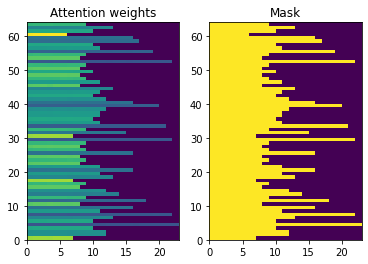

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [ ]:
attention_weights.shape
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

<Figure size 432x288 with 0 Axes>

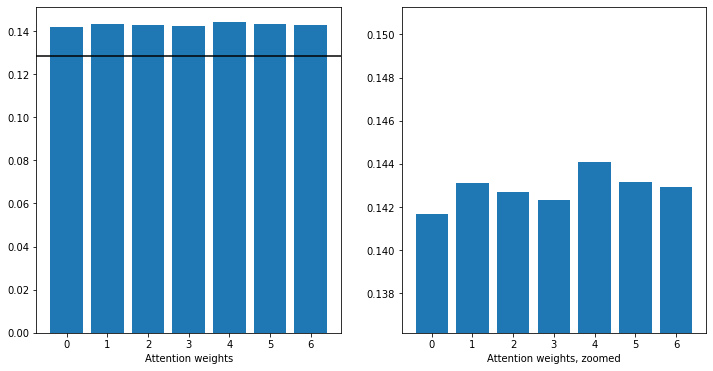

In [ ]:
#Attention weights for one sequence
plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

# zoom in
top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

**The decoder**

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer convets token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

In [ ]:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

**Implementation of the call method**

In [ ]:
def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
  shape_checker = ShapeChecker()
  shape_checker(inputs.new_tokens, ('batch', 't'))
  shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
  shape_checker(inputs.mask, ('batch', 's'))

  if state is not None:
    shape_checker(state, ('batch', 'dec_units'))

  # Step 1. Lookup the embeddings
  vectors = self.embedding(inputs.new_tokens)
  shape_checker(vectors, ('batch', 't', 'embedding_dim'))

  # Step 2. Process one step with the RNN
  rnn_output, state = self.gru(vectors, initial_state=state)

  shape_checker(rnn_output, ('batch', 't', 'dec_units'))
  shape_checker(state, ('batch', 'dec_units'))

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  shape_checker(context_vector, ('batch', 't', 'dec_units'))
  shape_checker(attention_weights, ('batch', 't', 's'))

  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
  attention_vector = self.Wc(context_and_rnn_output)
  shape_checker(attention_vector, ('batch', 't', 'dec_units'))

  # Step 5. Generate logit predictions:
  logits = self.fc(attention_vector)
  shape_checker(logits, ('batch', 't', 'output_vocab_size'))

  return DecoderOutput(logits, attention_weights), state

In [ ]:
Decoder.call = call

Using this decoder

In [ ]:
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

In [ ]:
# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [ ]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (64, 1, 3672)
state shape: (batch_size, dec_units) (64, 1024)


In [ ]:
#Sample a token according to the logits
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

In [ ]:
#Decode the token as the first word of the output
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['beings'],
       ['colorful'],
       ['goodbye'],
       ['returned'],
       ['lonely']], dtype='<U19')

**Use the decoder to generate a second set of logits**

In [ ]:
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['picked'],
       ['rubbed'],
       ['misfired'],
       ['revenues'],
       ['talent']], dtype='<U19')

### Training

**Loss function**

In [ ]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    shape_checker = ShapeChecker()
    shape_checker(y_true, ('batch', 't'))
    shape_checker(y_pred, ('batch', 't', 'logits'))

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)
    shape_checker(loss, ('batch', 't'))

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    shape_checker(mask, ('batch', 't'))
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)

**Implement the training step**

In [ ]:
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(input_text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor
    self.use_tf_function = use_tf_function
    self.shape_checker = ShapeChecker()

  def train_step(self, inputs):
    self.shape_checker = ShapeChecker()
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

The _preprocess will:
- Receive a batch of input_text, target_text from the tf.data.Dataset.
- Convert those raw text inputs to token-embeddings and masks.

In [ ]:
def _preprocess(self, input_text, target_text):
  self.shape_checker(input_text, ('batch',))
  self.shape_checker(target_text, ('batch',))

  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)
  self.shape_checker(input_tokens, ('batch', 's'))
  self.shape_checker(target_tokens, ('batch', 't'))

  # Convert IDs to masks.
  input_mask = input_tokens != 0
  self.shape_checker(input_mask, ('batch', 's'))

  target_mask = target_tokens != 0
  self.shape_checker(target_mask, ('batch', 't'))

  return input_tokens, input_mask, target_tokens, target_mask

In [ ]:
TrainTranslator._preprocess = _preprocess

The _train_step will:
- Run the encoder on the input_tokens to get the encoder_output and encoder_state.
- Initialize the decoder state and loss.
- Loop over the target_tokens:
- Calculate the gradient of the loss and use the optimizer to apply updates to the model's trainable_variables.

In [ ]:
def _train_step(self, inputs):
  input_text, target_text = inputs  

  (input_tokens, input_mask,
   target_tokens, target_mask) = self._preprocess(input_text, target_text)

  max_target_length = tf.shape(target_tokens)[1]

  with tf.GradientTape() as tape:
    # Encode the input
    enc_output, enc_state = self.encoder(input_tokens)
    self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
    self.shape_checker(enc_state, ('batch', 'enc_units'))

    # Initialize the decoder's state to the encoder's final state.
    # This only works if the encoder and decoder have the same number of
    # units.
    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in tf.range(max_target_length-1):
      # Pass in two tokens from the target sequence:
      # 1. The current input to the decoder.
      # 2. The target for the decoder's next prediction.
      new_tokens = target_tokens[:, t:t+2]
      step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
      loss = loss + step_loss

    # Average the loss over all non padding tokens.
    average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  # Apply an optimization step
  variables = self.trainable_variables 
  gradients = tape.gradient(average_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
  return {'batch_loss': average_loss}

In [ ]:
TrainTranslator._train_step = _train_step

The _loop_step method, added below, executes the decoder and calculates the incremental loss and new decoder state (dec_state).

In [ ]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
  input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

  # Run the decoder one step.
  decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

  dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
  self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
  self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
  self.shape_checker(dec_state, ('batch', 'dec_units'))

  # `self.loss` returns the total for non-padded tokens
  y = target_token
  y_pred = dec_result.logits
  step_loss = self.loss(y, y_pred)

  return step_loss, dec_state

In [ ]:
TrainTranslator._loop_step = _loop_step

**Test the training step**

In [ ]:
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [ ]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)

In [ ]:
TrainTranslator._tf_train_step = _tf_train_step

In [ ]:
translator.use_tf_function = True

In [ ]:
translator.train_step([example_input_batch, example_target_batch])

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.389841>}

In [ ]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.3574944>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.294251>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.0991335>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.2763376>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.3231807>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.7004666>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.6283717>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.4811306>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.3151865>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.211711>}

Wall time: 2min 7s


**Plot the result for loss**

....................................................................................................


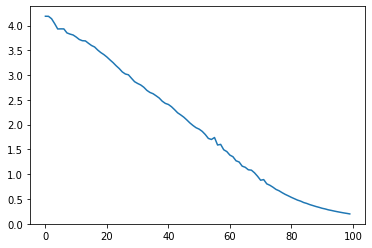

In [ ]:
losses = []
for n in range(100):
  print('.', end='')
  logs = translator.train_step([example_input_batch, example_target_batch])
  losses.append(logs['batch_loss'].numpy())

print()
plt.plot(losses)

We can confirm that the train step is working

**Build a fresh copy of the model to train from scratch**

In [ ]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

### Train the model

In [ ]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [ ]:
train_translator.fit(dataset, epochs=3,
                     callbacks=[batch_loss])

Epoch 1/3
119/119 [==============================] - 729s 6s/step - batch_loss: 4.4652
Epoch 2/3
119/119 [==============================] - 625s 5s/step - batch_loss: 3.4841
Epoch 3/3
119/119 [==============================] - 735s 6s/step - batch_loss: 2.8791


Text(0, 0.5, 'CE/token')

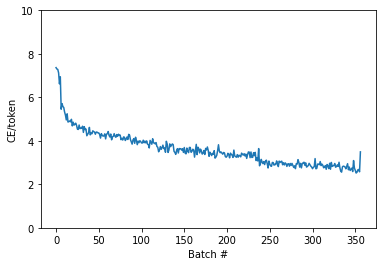

In [ ]:
#Plot result of Loss 
plt.plot(batch_loss.logs)
plt.ylim([0, 10])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

### Translate

In [ ]:
class Translator(tf.Module):

  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.experimental.preprocessing.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[START]'))
    self.end_token = index_from_string(tf.constant('[END]'))

In [ ]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

**Convert token IDs to text**

In [ ]:
def tokens_to_text(self, result_tokens):
  shape_checker = ShapeChecker()
  shape_checker(result_tokens, ('batch', 't'))
  result_text_tokens = self.output_token_string_from_index(result_tokens)
  shape_checker(result_text_tokens, ('batch', 't'))

  result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ')
  shape_checker(result_text, ('batch'))

  result_text = tf.strings.strip(result_text)
  shape_checker(result_text, ('batch',))
  return result_text

In [ ]:
Translator.tokens_to_text = tokens_to_text

In [ ]:
#Input ome random token IDs and see what it generates
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size())
translator.tokens_to_text(example_output_tokens).numpy()

array([b'impress chance', b'hungry down', b'fallen cry', b'no leave',
       b'drives shut'], dtype=object)

**Sample from the decoder's predictions**

In [ ]:
def sample(self, logits, temperature):
  shape_checker = ShapeChecker()
  # 't' is usually 1 here.
  shape_checker(logits, ('batch', 't', 'vocab'))
  shape_checker(self.token_mask, ('vocab',))

  token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
  shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

  # Set the logits for all masked tokens to -inf, so they are never chosen.
  logits = tf.where(self.token_mask, -np.inf, logits)

  if temperature == 0.0:
    new_tokens = tf.argmax(logits, axis=-1)
  else: 
    logits = tf.squeeze(logits, axis=1)
    new_tokens = tf.random.categorical(logits/temperature,
                                        num_samples=1)
  
  shape_checker(new_tokens, ('batch', 't'))

  return new_tokens

Translator.sample = sample

In [ ]:
#Test run this function on some random inputs
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[2607],
       [ 318],
       [3215],
       [2280],
       [ 950]], dtype=int64)>

**Implement the translation loop**

In [ ]:
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))

    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings.
  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}

In [ ]:
Translator.translate = translate_unrolled

In [ ]:
%%time
input_text = tf.constant([
    'Bạn không thể tin tưởng vào máy dịch được.', # "You can't trust computer translation."
    'Tom đánh piano giỏi hơn Mary.' # "Tom plays the piano better than Mary does."
])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

you have any quickly for common .
tom grabbed a lot and web rope conditions to play lying .

Wall time: 2.34 s


In [ ]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate

In [ ]:
%%time
result = translator.tf_translate(
    input_text = input_text)

Wall time: 1min 30s


In [ ]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

you dont know logged almost you eaten fallen .
tom changed the idea tom is here .

Wall time: 434 ms


### Visualize the process

In [ ]:
a = result['attention'][0]

print(np.sum(a, axis=-1))

[0.99999994 1.0000001  0.99999994 1.         0.9999999  0.99999994
 0.99999994 1.         1.         1.0000001  1.         0.9999999
 1.         0.99999994 0.99999994 1.         1.         0.99999994
 1.         1.0000001  1.         1.         1.         1.
 0.99999994 0.99999994 1.         1.         1.         0.99999994
 1.         1.         1.         1.0000001  1.0000001  1.
 1.         1.         1.         0.99999994 0.99999994 1.
 0.99999994 0.9999999  1.         1.         1.         0.99999994
 0.99999994 0.99999994]


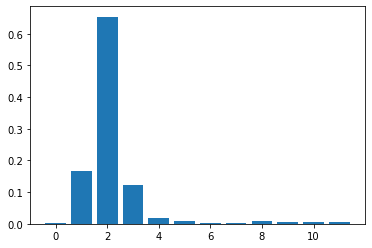

In [ ]:
_ = plt.bar(range(len(a[0, :])), a[0, :])

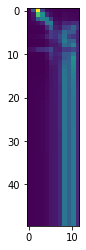

In [ ]:
plt.imshow(np.array(a), vmin=0.0)

### Labeled attention plots

In [ ]:
#Labeled attention plots
def plot_attention(attention, sentence, predicted_sentence):
  sentence = tf_lower_and_split_punct(sentence).numpy().decode().split()
  predicted_sentence = predicted_sentence.numpy().decode().split() + ['[END]']
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  attention = attention[:len(predicted_sentence), :len(sentence)]

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.suptitle('Attention weights')

C:\Users\Nhung\AppData\Local\Temp/ipykernel_31496/2069917776.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\Nhung\AppData\Local\Temp/ipykernel_31496/2069917776.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


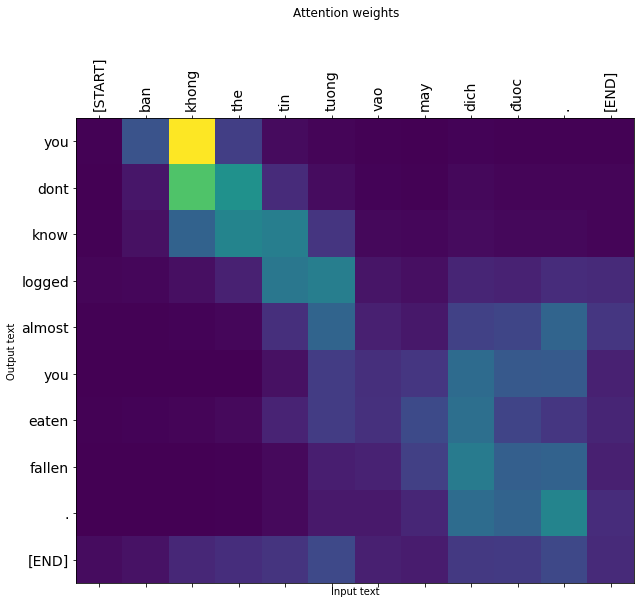

In [ ]:
i=0
plot_attention(result['attention'][i], input_text[i], result['text'][i])

In [ ]:
%%time
three_input_text = tf.constant([
     #It might explode.
    'Nó có thể nổ.',
    #It's payback time.	
    'Đã đến lúc trả đũa rồi.',
    # You're not allowed to camp here.'
    'Anh không được phép cắm trại ở đây.'
])

result = translator.tf_translate(three_input_text)

for tr in result['text']:
  print(tr.numpy().decode())

print()

she isnt here .
the book will run to bed .
first dont know her right long whenever me .

Wall time: 1.62 s


In [ ]:
result['text']

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'she isnt here .', b'the book will run to bed .',
       b'first dont know her right long whenever me .'], dtype=object)>

C:\Users\Nhung\AppData\Local\Temp/ipykernel_31496/2069917776.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\Nhung\AppData\Local\Temp/ipykernel_31496/2069917776.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


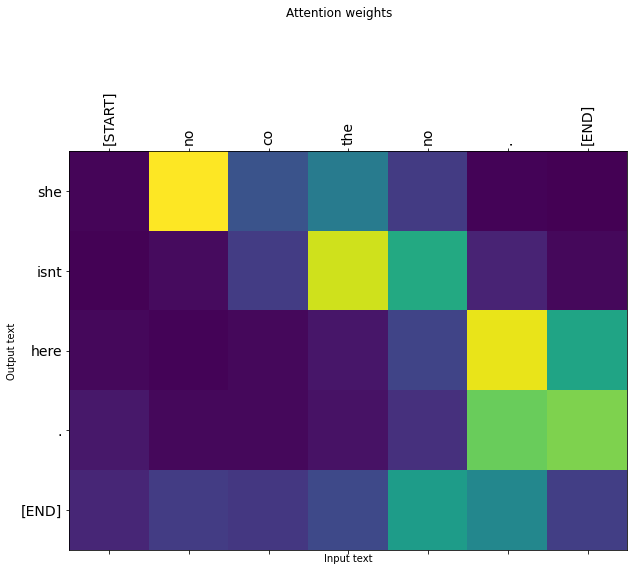

In [ ]:
i = 0
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

C:\Users\Nhung\AppData\Local\Temp/ipykernel_31496/2069917776.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\Nhung\AppData\Local\Temp/ipykernel_31496/2069917776.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


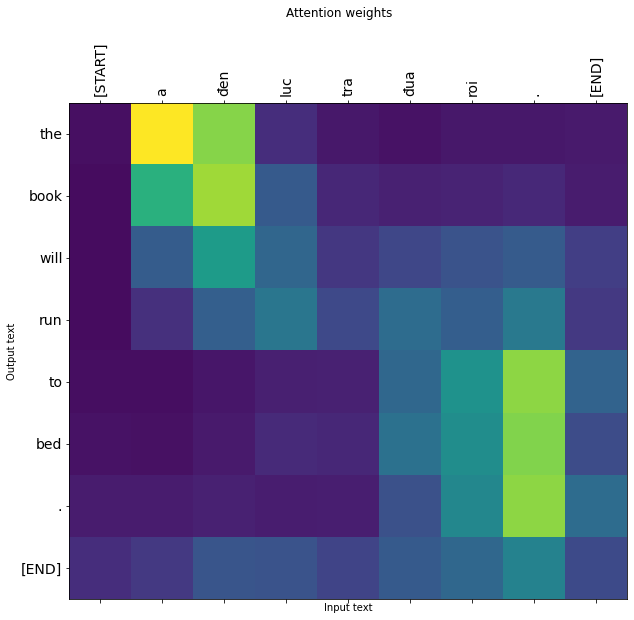

In [ ]:
i = 1
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

C:\Users\Nhung\AppData\Local\Temp/ipykernel_31496/2069917776.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\Nhung\AppData\Local\Temp/ipykernel_31496/2069917776.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


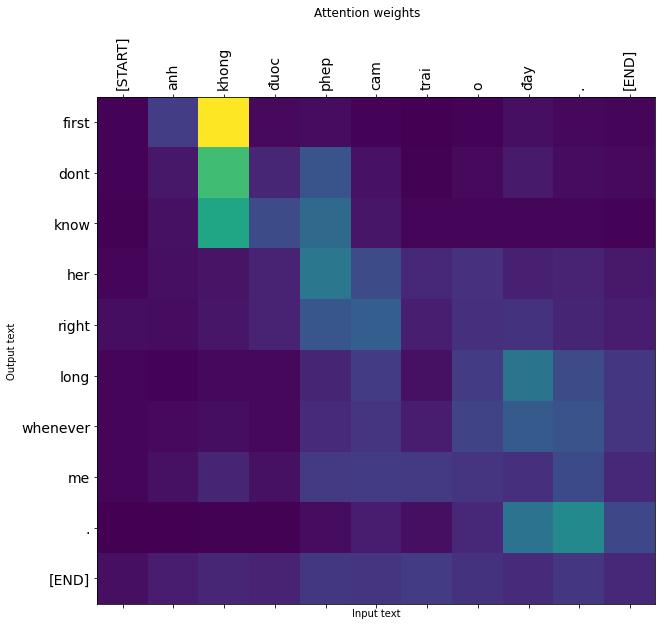

In [ ]:
i = 2
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

The short sentences often work well, but if the input is too long the model literally loses focus and stops providing reasonable predictions. There are two main reasons for this:

The model was trained with teacher-forcing feeding the correct token at each step, regardless of the model's predictions. The model could be made more robust if it were sometimes fed its own predictions.

The model only has access to its previous output through the RNN state. If the RNN state gets corrupted, there's no way for the model to recover. Transformers solve this by using self-attention in the encoder and decoder.

In [ ]:
long_input_text = tf.constant([inp[-1]])

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(targ[-1])))

Expected output:
 I learned nothing from the teacher.


C:\Users\Nhung\AppData\Local\Temp/ipykernel_31496/2069917776.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\Nhung\AppData\Local\Temp/ipykernel_31496/2069917776.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


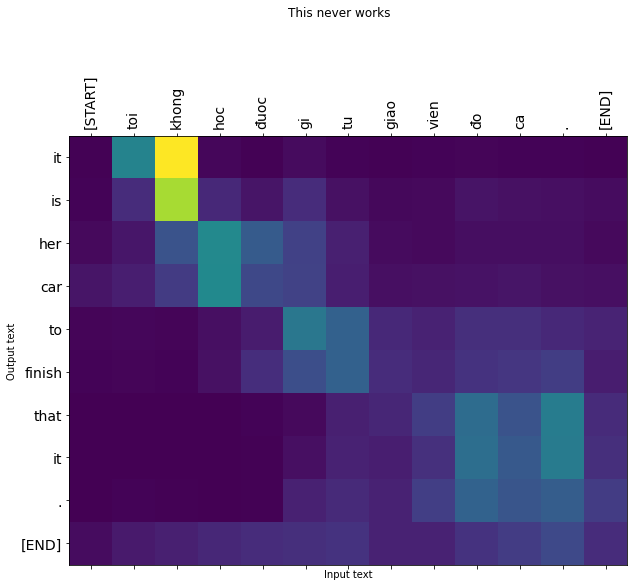

In [ ]:
result = translator.tf_translate(long_input_text)

i = 0
plot_attention(result['attention'][i], long_input_text[i], result['text'][i])
_ = plt.suptitle('This never works')

### Export

In [ ]:
tf.saved_model.save(translator, 'translator',
                    signatures={'serving_default': translator.tf_translate})

INFO:tensorflow:Assets written to: translator\assets


INFO:tensorflow:Assets written to: translator\assets


In [ ]:
reloaded = tf.saved_model.load('translator')
result = reloaded.tf_translate(three_input_text)

In [ ]:
%%time
result = reloaded.tf_translate(three_input_text)

for tr in result['text']:
  print(tr.numpy().decode())

print()

he is he safe .
the money is there my hair against school .
not dont see saying me tired .

Wall time: 576 ms
